# Enzyme Commission Class with Ligands

# Overview

**Questions**

1. How are enzymes classified?
2. How can I search the PDB for ligands that bind to a specific enzyme class?

**Learning Objectives**

1. Understand the hierarchical classification of enzymes using the Enzyme Commission (EC) system.
2. Use the RCSB Search API to find ligands that bind to a specific enzyme class.

Enzymes ar Enzymes are biological catalysts and most enzymes are proteins (at least that's our current thinking). To systematize the study of enzymes, IUPAC (the International Union of Pure and Applied Chemistry) has organized enzymes in a hierarchical class structure, with 7 top level classes and a total of 4 levels in the hierarchy.

These classes are called the Enzyme Commission (EC) classes, and the hierarchy is called the EC system. Each enzyme is assigned an EC number based on the type of reaction it catalyzes. In this notebook, we will use the RCSB Search API to find ligands that bind to a specific enzyme class.

# The 7 Enzyme Classes

The BRENDA Enzyme Database contains detailed information about enzymes and includes a browser tree for enzyme classes. The 7 major classes of enzymes on the top level of the tree are

1. Oxidoreductases
2. Transferases
3. Hydrolases
4. Lyases
5. Isomerases
6. Ligases
7. Translocases

On the BRENDA Home Page, you can search for an enzyme by name and find its Enzyme Commision (EC) number, and a lot more detail as well. The first image below is the search for the enzyme HMG CoA Reductase, the control point for cholesterol synthesis. The second image shows the initial results page, which includes the EC number.

In this notebook, we will focus on trypsin, an enzyme produced by your pancreas that helps to digest proteins in your small intestine. It is a member of family called serine hydrolases. Members of this family use water to break bonds in proteins, lipids and carbohydrates. They are involved in digestion, cell signalling and blood clotting. The EC# for trypsin is 3.4.21.4. Here is the meaning of each level of the hierarchy:

3 - Hydrolase
3.4 - acting on peptide bonds
3.4.21 - serine endopeptidase
3.4.21.4 - trypsin

This notebook is intended to help users find ligands for use with docking studies. We are looking for ligands that will bind to trypsin, with the intention of seeing if they will bind to other serine hydrolases that might be interesting. Here are the steps we will follow in the process, all of which will employ the rcsbsearchapi package.

1. Find PDB structures of a given Enzyme Commission class.
2. Select those structures that contain bound small molecules with molecular weights between 300 and 600.
3. Output a list of those ligands
4. Save the ligand structures to the "ligands_for_EC_class_#" folder.

In [2]:
# Import the components of rcsbsearchapi needed for this search
from rcsbapi.search import AttributeQuery as attrs

1. A ligand is any molecule that binds to a protein (including enzymes) to influence its function, while an enzyme is a protein that catalyzes chemical reactions, often by binding to ligands such as substrates.

2. The ligand’s main role is binding, whereas the enzyme’s main role is catalysis.

3. Enzymes are significantly bigger than ligands, both in terms of physical size and molecular weight

4. Ligands are much smaller molecules that bind to enzymes (or other proteins). Ligands can be small organic molecules, ions, or even small peptides, but they are almost always much smaller than the enzyme itself. For example, glucose (a common ligand for enzymes) has a molecular weight of about 180 Da, which is orders of magnitude smaller than a typical enzyme.

# Making queries

To make a query with rcsbsearchapi you first must know what you are looking for. I find it helpful to actually write this out by hand sometimes. Here are the characteristics I am looking for in ligands that bind to a specific Enzyme Commission Class of a protein.

1. EC Class. I will focus on the EC class for trypsin, 3.4.21.4, but any class should work.
2. Ligands. I am looking for ligands that are larger than a single atom (e.g., potassium ion) or a buffer molecule (phosphate), but of a size that consists of 10-30 heavy atoms, so I will aim for a molecular weight between 300 and 800.

Please note that you can use this interface to search for dozens of attributes associated with a PDB entry. The attribute that we will use to look for proteins that have the EC# = 3.4.21.4 is rcsb_polymer_entity.rcsb_ec_lineage.id. Other searchable attributes include the abbreviated journal title for the primary citation, rcsb_primary_citation.rcsb_journal_abbrev, the method used to determine the structure exptl.method, or specific molecules that are part of PDB entries pdbx_reference_molecule.class.

A chemical component in a PDB (Protein Data Bank) structure refers to any distinct chemical entity present in the structure, including:

- Standard and modified amino acids (building blocks of proteins)
- Standard and modified nucleotides (building blocks of DNA/RNA)
- Small molecule ligands (such as drugs, cofactors, or inhibitors)
- Metal ions and solvent molecules (like water)

Each chemical component is assigned a unique three-character alphanumeric code (e.g., “GLC” for glucose, “HEM” for heme, “TYL” for Tylenol)

In [5]:
# There will be three components to the query, which will be labeled q1, q2 and q3.

ECnumber = "3.4.21.4"

q1 = attrs("rcsb_polymer_entity.rcsb_ec_lineage.id", "exact_match", ECnumber)       # looking for trypsin structures with EC = 3.4.21.4
q2 = attrs("chem_comp.formula_weight", "greater_or_equal", 300)                     # setting the lower limit for molecular weight
q3 = attrs("chem_comp.formula_weight", "less_or_equal", 800)                        # setting the lower limit for molecular weight

query = q1 & q2 & q3                     # query (after combining with &) is a query object-it represents the search but does not execute it.

resultL = list(query())                  # Executes the combined query and returns an iterator of results

print(resultL[0:10])
print(f"There are {len(resultL)} trypsin structures that contain ligands in the RCSB PDB.")

['1AQ7', '1AUJ', '1AZ8', '1BJV', '1BTW', '1BTX', '1BTZ', '1C1S', '1C1T', '1C2D']
There are 187 trypsin structures that contain ligands in the RCSB PDB.


# Finding the ligands

This query provided the list of the PDB entries for trypsins (EC # 3.4.21.4) that contain ligands between 300 and 800 molecular weight. We printed the first 10 of these results using print(resultL[0:10]).

Why would we choose to have ligands with molecular weights between 300 and 800? We are interested in molecules that are large enough to bind to and fill up the active site of trypsin. Small molecules with molecular weights less than 300 are likely to be individual ions (K+ or Na+). Molecules with molecular weights greater than 800 will fill more than the active site of an enzyme.

Here is an image of one of the ligands from the search that we're going to learn to download. It is identified in the Protein Data Bank as 13U. As a group we will look at some of the features that make this ligand interesting.

The last statement in the previous cell

print("There are", len(resultL), "trypsin structures that contain ligands in the RCSB PDB.")

tells us how many PDB entries have ligands of that size. The default return item for the query is structure, which provides the four character alphanumeric entry for the full structure in the PDB. We want to identify and download the ligands that are bound to these PDB structures, so we need to switch return types.

To get the ligand, instead of returning the structure (Enzyme + ligand), we will request a return type of mol_definition which will then return the three character alphanumeric entry for the ligand. Other possible return types are polymer entities, assemblies, and non-polymer entities.

In [6]:
molResultL = list(query("mol_definition"))
print(f"There are {len(molResultL)} ligands for EC number {ECnumber} in the list.")
print(molResultL[0:10])

There are 119 ligands for EC number 3.4.21.4 in the list.
['0CA', '0CB', '0G6', '0IV', '0KV', '0ZG', '0ZW', '0ZX', '0ZY', '10U']


**Where can we go to download the ligand files?**

To download the files for ligands bound to trypsin in the RCSB PDB, execute the two cells above for finding the trypsin ligands. This will reset the results to the ones we want.

Once this is done, the next step is to determine exactly what we want to download. These ligand files in the PDB are avaiable for download in several formats. A full list and description can be found in the Small Molecule File table on the RCSB PDB File Download Services page, which is pasted in here.

From this table, we want the ideal coordinate ligand files in mol2 format, which we will later convert to another format called pdbqt for docking.

# How do we download the ligand files?

There are several options for downloading files - we will use a Python libary called requests. In the following cells, we will import the library, requests, download a single file from the RCSB PDB using the requests.get function, and check to make sure the file downloaded properly to the ligands folder. If that is successful, we'll use a for loop to download all of the files from our molResultL list to the ligands folder.

In [1]:
import requests
import os

In [8]:
# Download one of the files from our list: 11U.mol2

res11U_mol2 = requests.get('https://files.rcsb.org/ligands/download/11U_ideal.sdf')

In [10]:
# check to see that the file downloaded properly. A status code of 200 means everything is okay.

res11U_mol2.status_code

200

In [11]:
# Make a ligands folder for our clients. 
os.makedirs("ligands", exist_ok=True)

with open("ligands/res11U_mol2", 'w+') as file:
    file.write(res11U_mol2.text)

In [12]:
file1 = open("ligands/res11U_mol2", 'r')
file_text = file1.read()
print(file_text)

11U
  CCTOOLS-0919241032

 59 61  0  0  1  0  0  0  0  0999 V2000
    2.4220    0.4070    0.3360 C   0  0  0  0  0
    2.0060   -0.6420    0.7800 O   0  0  0  0  0
    3.8690    0.5350   -0.0630 C   0  0  0  0  0
    4.5590   -0.7380    0.1810 N   0  0  0  0  0
    5.9760   -0.6510   -0.1970 C   0  0  0  0  0
    6.7790   -0.0680    0.9670 C   0  0  0  0  0
    8.2550    0.0240    0.5730 C   0  0  0  0  0
    8.7810   -1.3740    0.2400 C   0  0  0  0  0
    7.9780   -1.9570   -0.9250 C   0  0  0  0  0
    6.5020   -2.0480   -0.5310 C   0  0  0  0  0
    1.5890    1.4580    0.1990 N   0  0  0  0  0
    0.1600    1.4690    0.5420 C   0  0  0  0  0
   -0.5770    0.4580   -0.2980 C   0  0  0  0  0
    0.0270   -0.2120   -1.1080 O   0  0  0  0  0
   -0.3710    2.8880    0.2460 C   0  0  0  0  0
    0.9140    3.7560    0.2780 C   0  0  0  0  0
    1.9600    2.7850   -0.3250 C   0  0  0  0  0
   -1.9070    0.2990   -0.1490 N   0  0  0  0  0
   -2.6230   -0.6850   -0.9660 C   0  0  0  0  0
   

# Downloading all of the ligands using a for loop

Now that we know that our process functions, we will use a for loop to download the entire list of ligands (all 112) in a single cell. Here are the steps we will take:

1. Define a variable, baseUrl, for the URL where the ligand files are located. The URL only lacks the specific name of the ligand file.
2. Set up a for loop to go through each of the items (as ChemID) in the molResultL list that was generated above.
3. Assign the filename based on a variable (the 3-letter name of the ligand as ChemID followed by _ideal.mol2) to the variable cFile.
4. Assign the full URL (as cFileUrl) that we want to use to download the data from the RCSB PDB API. Notice that the URL will consist of the baseUrl (defined in the first line of the cell) followed by the name of the file we just defined, which is now assigned to the variable, cFile.
5. Tell the notebook that we want the file (CFileLocal) to be written to the ligands folder, using the os.path command.
6. Use the API call via requests.get to download the data from the RCSB PDB.
7. Write the file using the with open function.

If all goes according to plan, this should download all of the ligands on our list to the ligands folder.

In [13]:
baseUrl = "https://files.rcsb.org/ligands/download/"

for ChemID in molResultL:
    cFile = f"{ChemID}_ideal.sdf"
    cFileUrl = baseUrl + cFile
    cFileLocal = "ligands/" + cFile
    response = requests.get(cFileUrl)
    with open(cFileLocal, "w+") as file:
        file.write(response.text)

# Manipulating Molecules with RDKit

# Overview

**Questions**

* How can I load files using RDKit?
* How can I manipulate and create new molecules from an existing molecule?

**Objectives**

* To understand the utility of the different Python libraries utilized in this notebook
* To explain the features of SMILES strings and how they are used to communicate chemical structures to computers
* To modify a ligand file in a meaningful way (e.g., testing stereochemistry or electrochemistry) and to save the modified file for future use

In this notebook, we load an "ideal" structure for a ligand obtained in the EC_class_ligands_search notebook by pulling coordinates from the PDB and then we manipulate it using RDKit.

The approach taken here is manual and hands on. We will pick atoms of interest visually, then morph atomic numbers in order to change a carbon atom into a nitrogen atom, and then add a methyl group by changing a hydrogen atom into a carbon atom.

By loading our molecule from an ideal structure with 3D coordinates, we can ensure that we're already near a "good structure" for our manipulated molecules and our geometry optimization will be more likely to succeed.

[18:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


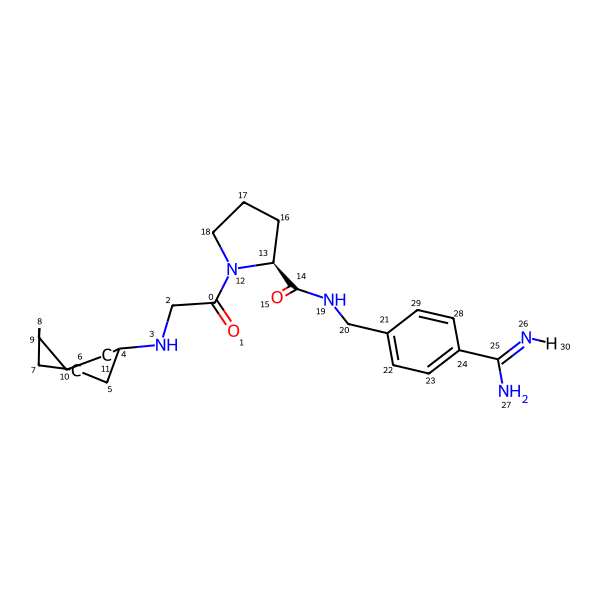

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# Configuration for displaying in Jupyter notebooks.
IPythonConsole.ipython_useSVG = True                      # Use SVG for higher quality images
IPythonConsole.drawOptions.addAtomIndices = True          # Show atom indices
IPythonConsole.molSize = 600,600                          # Set size of image

ligand = Chem.MolFromMolFile("ligands/13U_ideal.sdf")
ligand

# Modifying a ligand

We will modify 13U: N-cyclooctylglycyl-N-(4-carbamimidoylbenzyl)-L-prolinamide from the previous notebook as our starting point to create two additional ligands. In one case, we will substitute nitrogen for carbon in an aromatic ring. In the second case, a carbon will be added to the original aromatic ring.

Please notice the index numbers attached to each atom in the ligand image generated by the previous cell. This is possible because of an earlier command that we used to display these index numbers.

IPythonConsole.drawOptions.addAtomIndices = True  # Show atom indices

We will use these index numbers to tell the Python code which atoms to modify.

[19:00:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


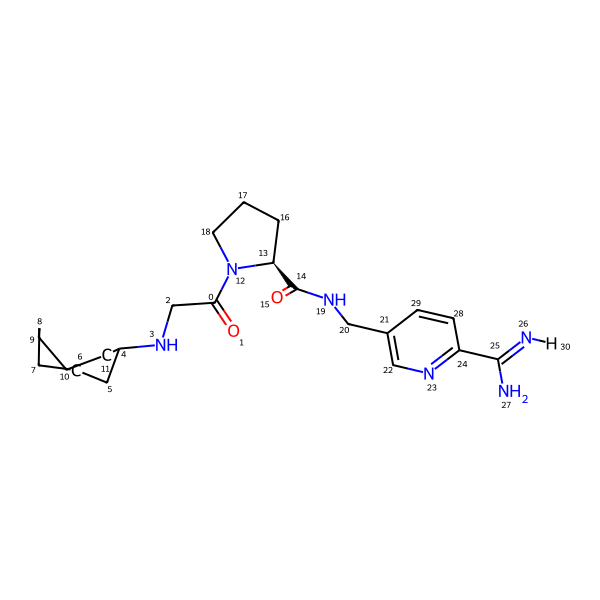

In [34]:
# load a duplicate copy of 13U to manipulate
mol_ligand_N = Chem.MolFromMolFile("ligands/13U_ideal.sdf")
# change carbon in ring to a nitrogen
mol_ligand_N.GetAtomWithIdx(23).SetAtomicNum(7)

mol_ligand_N

If we see that the nitrogen we've added has a hydrogen attached to it. In order to maintain aromaticity, we need to remove this hydrogen. But we don't have hydrogen at the nitrogen atom. 

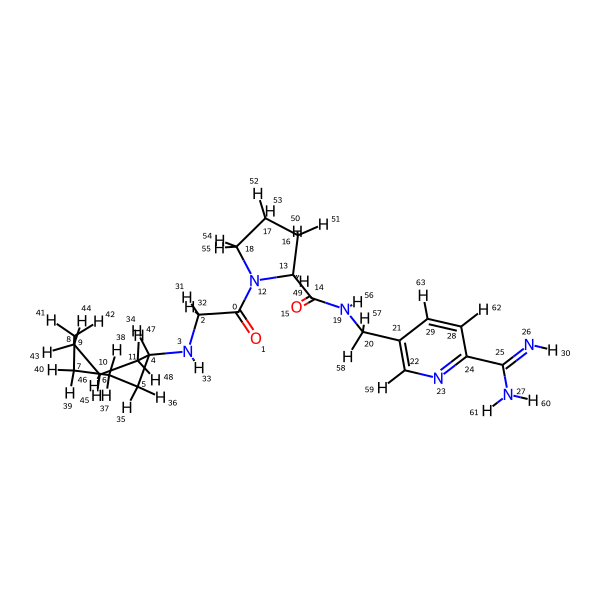

In [37]:
atom = mol_ligand_N.GetAtomWithIdx(23)
atom.SetNumExplicitHs(0)    # Set the number of explicit hydrogens to 0.
mol_ligand_N = Chem.AddHs(mol_ligand_N, addCoords= True)
mol_ligand_N             # Hydrogen is present and its index is 60. 

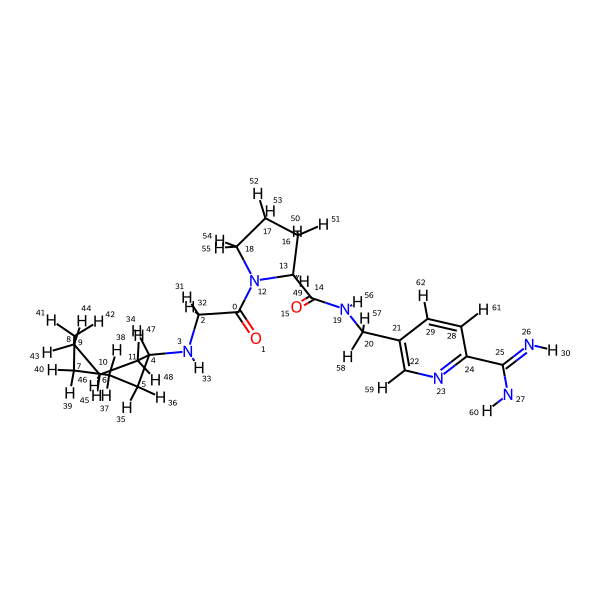

In [38]:
# Removing the atom using index number. 
emol = Chem.EditableMol(mol_ligand_N)
emol.RemoveAtom(60)
mol_ligand_N = emol.GetMol()
mol_ligand_N

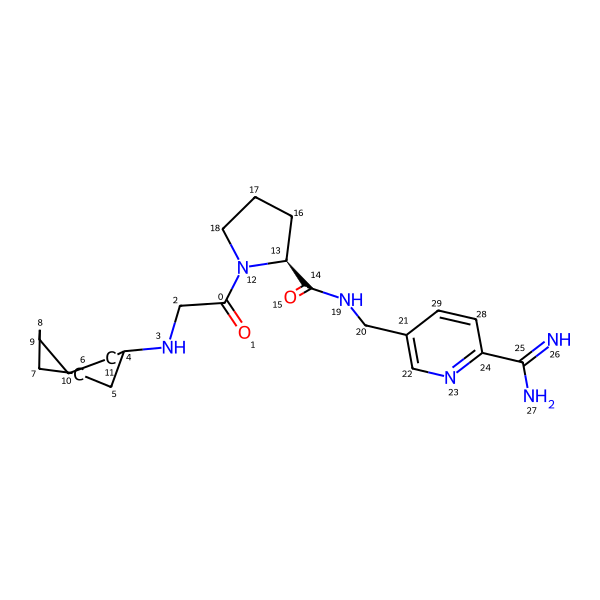

In [45]:
mol_ligand_N = Chem.RemoveAllHs(mol_ligand_N)
mol_ligand_N

Now we'll perform the same operations, but this time add a methyl group to the ring. In this notebook, we're going to be tricky and morph the hydrogen on the carbon atom to a carbon atom. However, a more "standard" way to do this would be to create two molecule fragments and then merge them together. To be consistent with our above approach, we'll do it the tricky way.

[18:32:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


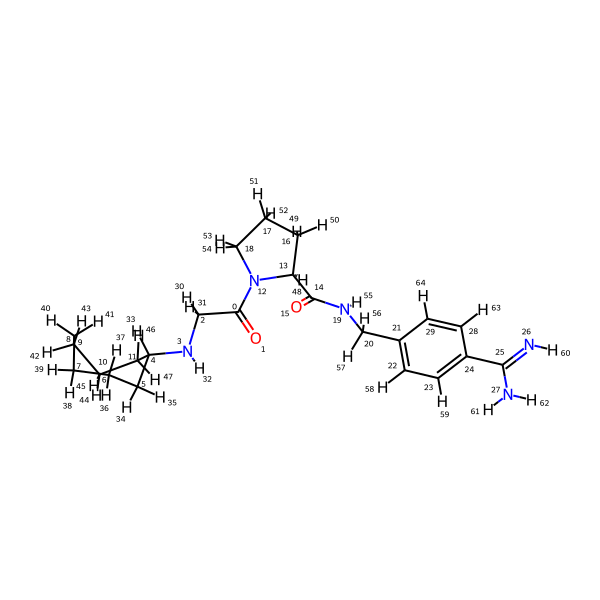

In [6]:
# load another duplicate of the original ligand, but keep the hydrogens.
mol_ligand_methyl = Chem.MolFromMolFile("ligands/13U_ideal.sdf", removeHs = False)
mol_ligand_methyl

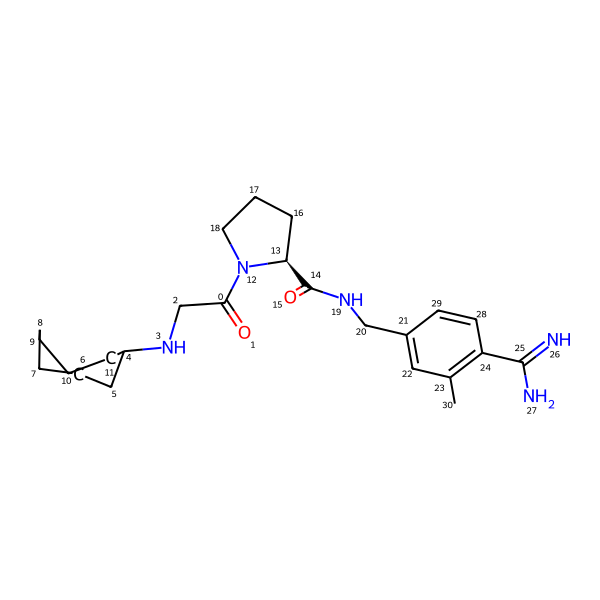

In [7]:
# Use the index number to select the atom we want to change - look at image to see we want to morph atom 59.
atom = mol_ligand_methyl.GetAtomWithIdx(59)

atom.SetAtomicNum(6)               # Change the atom to carbon
atom.SetNumExplicitHs(3)           # Add 3 explicit hydrogens to the carbon

mol_ligand_methyl =  Chem.RemoveAllHs(mol_ligand_methyl)
mol_ligand_methyl

Now that we have our manipulated molecules, we'll optimize them using RDKit and save them.

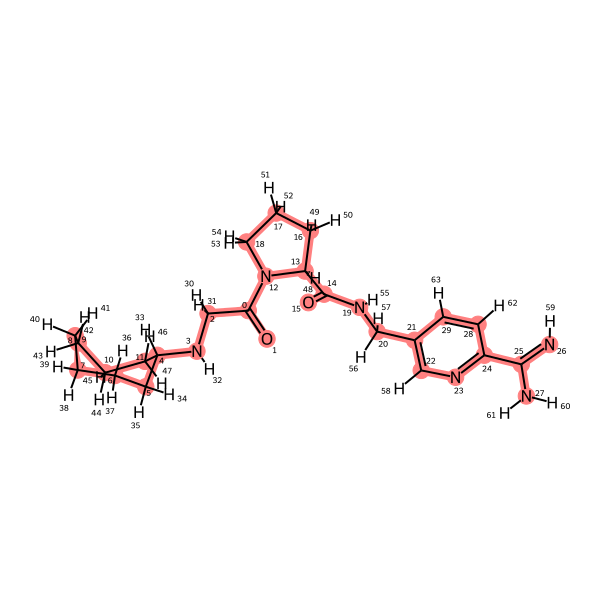

In [46]:
from rdkit.Chem import AllChem

mol_ligand_NH = Chem.AddHs(mol_ligand_N)

# Do a constrained embedding to keep the ligand in the same position
# this allows for the hydrogens to be added in reasonable locations, but keeps
# the heavy atoms in the same position
# See https://rdkit.org/docs/source/rdkit.Chem.AllChem.html#rdkit.Chem.AllChem.ConstrainedEmbed
mol_ligand_NH
constrained_mol = AllChem.ConstrainedEmbed(mol_ligand_NH, mol_ligand_N, useTethers=True)
constrained_mol

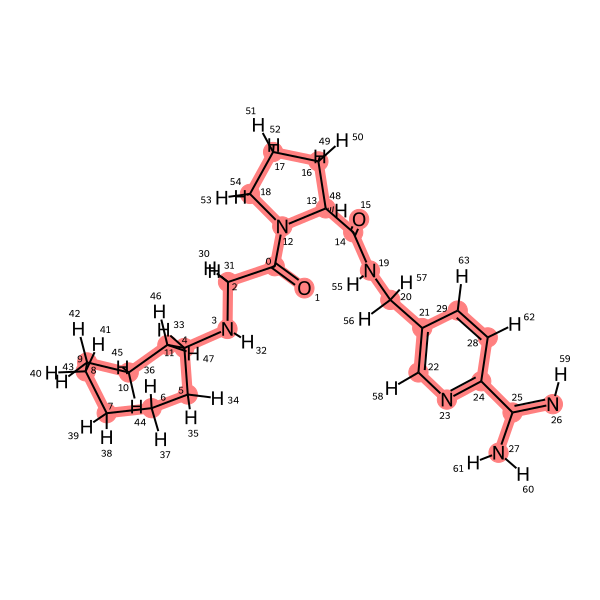

In [48]:
# Perform geometry optimization
opt_N = AllChem.MMFFOptimizeMolecule(mol_ligand_NH)
mol_ligand_NH

In [51]:
# save to new files
import os

os.makedirs("ligands_to_dock", exist_ok=True)

ligand_H = Chem.MolFromMolFile("ligands/13U_ideal.sdf", removeHs=False)

# save modified ligands sdf file - make sure all contain hydrogens and place 
# in a folder of ligands to dock.
Chem.MolToMolFile(ligand_H, "ligands_to_dock/13U.sdf")
Chem.MolToMolFile(mol_ligand_NH, "ligands_to_dock/13U_modified_N.sdf")

[20:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


[12:04:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


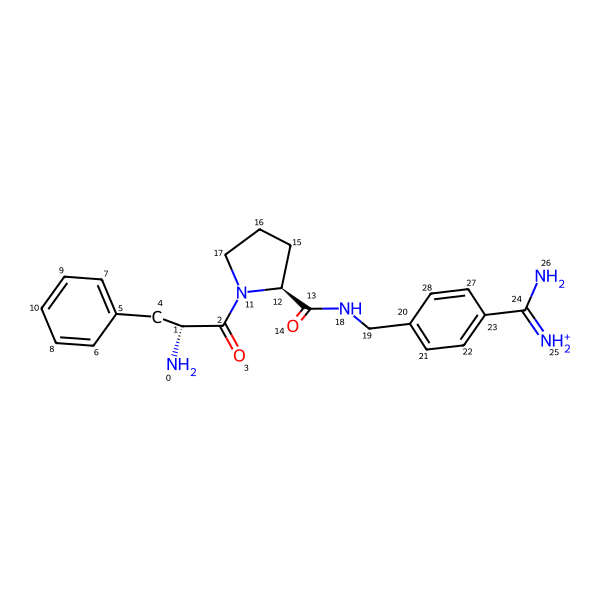

In [61]:
ligand32 = Chem.MolFromMolFile("ligands/32U_ideal.sdf")
ligand32

In [65]:
mod_ligand_OH = Chem.MolFromMol2File("ligands/32U_ideal.sdf", removeHs = False)

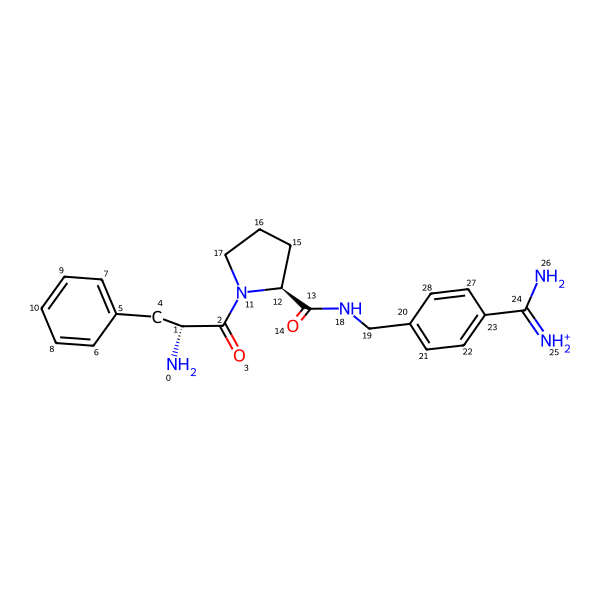

In [69]:
ligand32

[12:11:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


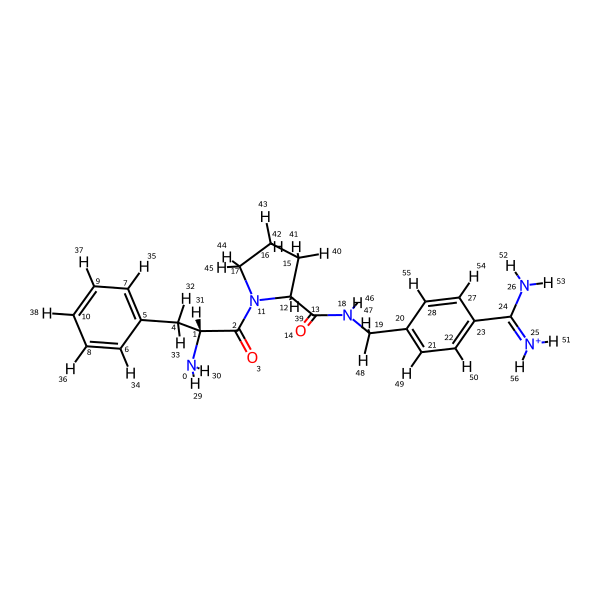

In [77]:
mod_ligand_OH = Chem.MolFromMolFile("ligands/32U_ideal.sdf", removeHs = False)
mod_ligand_OH

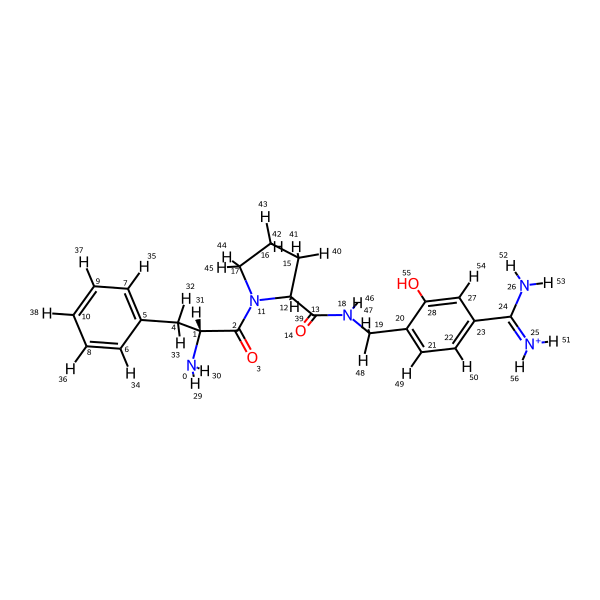

In [78]:
atom = mod_ligand_OH.GetAtomWithIdx(55)
atom.SetAtomicNum(8)   # Convert H to O.
mod_ligand_OH

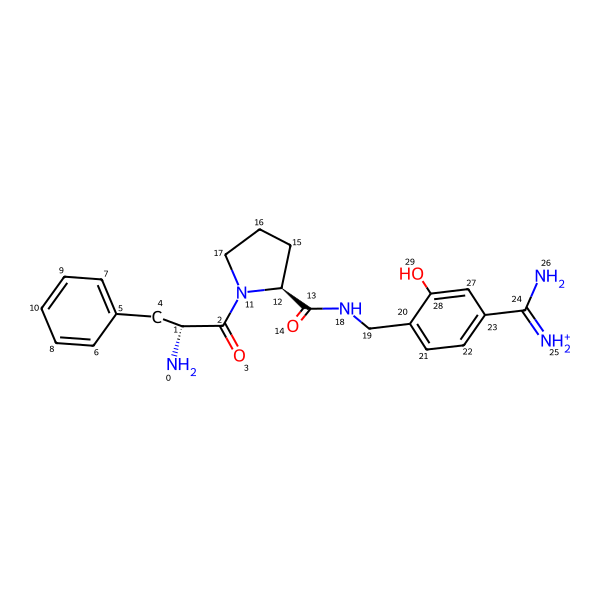

In [79]:
mod_ligand_OH = Chem.RemoveAllHs(mod_ligand_OH)    # Removes all the Hs
mod_ligand_OH

# Visualizing the Binding Site of a Protein-Ligand Complex

**Learning Objectives**

* Use NGLView to view the 3D structure of our protein and ligand.
* Prepare molecule structures using PDQ2PQR and RDKit.
* Analyze the interactions of the protein in the binding site using a 2D map and ProLIF.

Before we begin our docking calculations, we will likely want to investigate the binding site of our ligand of interest. We will want to look at the binding pocket and the interactions of the ligand with the protein residues. For the rest of our studies, we will choose the ligand 13U. A trypsin structure where this ligand is bound is 2ZQ2.

## Downloading the Structure

First we will need to download our protein structure. We will download 2ZQ2, which is a trypsin structure with our ligand of interest bound.

We will use a similar strategy to our last notebook for getting the file. We will use Python's request module and a URL from the Protein Data Bank.

In [80]:
import os 
import requests

os.makedirs("structures", exist_ok=True)

pdb_id = "2zq2"

pdb_request = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb")
pdb_request.status_code

200

After downloading, we will write the text to a file.

In [81]:
with open(f"structures/{pdb_id}.pdb", "w+") as f:
    f.write(pdb_request.text)

In [82]:
import MDAnalysis as mda

u = mda.Universe(f"structures/{pdb_id}.pdb")

We will create separate variables for the protein and ligand. We can select all protein residues in MDAnalysis using the word "protein" in the select_atoms function. Then, we will select our ligand using resname 13U. This corresponds to the residue name in the PDB we downloaded.

In [83]:
protein = u.select_atoms("protein")
ligand = u.select_atoms("resname 13U")

What about the "A" and "B" in the atom names?

* C14A13U: The A means this is the "A" version (or conformation) of atom C14.
* C14B13U: The B means this is the "B" version (another possible position) of atom C14.

This happens when the crystal structure can't decide exactly where the atom is, so it lists both possibilities:

* A conformation is present 61% of the time (occupancy 0.61)
* B conformation is present 39% of the time (occupancy 0.39)

The coordinates for A and B are slightly different, showing the two possible places the atom could be.

In [84]:
protein = u.select_atoms("protein")
ligand_A = u.select_atoms("resname 13U and altLoc A")
ligand_B = u.select_atoms("resname 13U and altLoc B")

## Making a Map of Ligand Contacts

To get an even better idea of how our ligand is binding to the protein, we might choose to make a 2D or 3D map of ligand contacts with protein residues. In this analysis, we'll want to know how the ligand is interacting with the protein residues including if it is making hydrogen bonds, Van Der Waals interactions, etc.

We will use a library called ProLIF for this analysis. ProLIF is short for "Protein-Ligand Interaction Fingerprints" and it " is a tool designed to generate interaction fingerprints for complexes made of ligands, protein, DNA or RNA molecules extracted from molecular dynamics trajectories, docking simulations and experimental structures." (quote taken from ProLIF docs).

Before we use ProLIF, we first have to make sure our ligand and protein file are prepared properly. Hydrogens are absent in most PDB files because they are not well resolved by methods like X-Ray crystallography. We'll need to add them back in in order to complete our analysis of the binding site.

This process can actually be quite involved, as we'll see below.

We will start by saving new PDBs of our selections from MDAnalysis. Then, we will add hydrogens.

In [85]:
protein.write(f"structures/protein_{pdb_id}.pdb")
ligand_A.write(f"structures/ligand_A.pdb")

/opt/homebrew/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


## Structure Preparation

Before we run the analysis, we need to make sure our protein and ligand have hydrogen atoms. This can be difficult because we must check many things about our molecule. We must make sure that protein residues are correctly identified in the structures. PDB files can be messy, and they often need to be checked for missing atoms or otherwise cleaned up. We also need to check that our bond orders for our ligand are correct and hydrogens are correctly added. Whenever you are working with a PDB file, it is absolutely crucial that you check for things like missing atoms in the PDB.

## Protein Preparation

For fixing our protein, we will use a specialized program called PDB2PQR that is made for working with biomolecules like proteins. The advantage of using PDB2PQR is that it will check our protein for missing atoms and multiple occupancy in the protein, and it will pick positions and add missing atoms.

We will use the command-line interface of this program. This means that you would usually type the command below into your terminal You can run command line commands in the Jupyter notebook by putting a ! in front of the command.

This command takes your original protein structure (protein_2zq2.pdb), adds hydrogens and assigns protonation states as they would be at pH 7.4, and writes:

* a new PDB file with hydrogens (protein_h.pdb).
* a PQR file (protein_2zq2.pqr) with charges and radii.
  
These files are useful for further computational analyses, such as calculating electrostatic potentials.

In [88]:
! pdb2pqr --pdb-output=structures/protein_h.pdb --pH=7.4 structures/protein_2zq2.pdb structures/protein_2zq2.pqr

INFO:PDB2PQR v3.7.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: structures/protein_2zq2.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     2>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 223 residues and 1625 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 4 missing atoms in biomolecule.
INFO:Added atom CG to residue LYS A 222 at coordin

This structure had some ambiguous atom positions and some missing atoms. The software chose one position for ambiguous atoms, tried to rebuild missing atoms, and then prepared the structure for further use (like adding hydrogens and adjusting geometry). This is common when working with experimental protein structures!

In [89]:
protein_h = mda.Universe("structures/protein_h.pdb")

## Ligand Preparation

Adding hydrogens to our ligand is a little bit more difficult. We can't just use PDB2PQR in this case because our ligand does not contain known or standard residues like the protein.

We will need to take the ligand position in the PDB and add hydrogens to it. Many programs rely on the distance between atoms to infer bond order, however, our ligand might not have bond lengths such that the proper bond orders are always recognized. We will want to make sure that we have a proper reference in order to ensure that we are setting bond orders correctly.

We will use the ideal ligand we downloaded as a reference and use a small molecule manipulation software called RDKit to match bond orders and add hydrogens.

We will use Chem from RDKit to load in our structure, then a function called AssignBondOrdersFromTemplate to assign the correct bond orders. This is useful for us because the molecule in the PDB file does not have bond order information, and based on atom distances this might not be correctly determined. We can use our ideal ligand, which does have bond order information, to make sure this is correctly set for our structures. We have to make sure to remove all of the hydrogens from both our reference and original ligand structure before we can fix the molecule.

In [90]:
from rdkit import Chem

from rdkit.Chem.AllChem import AssignBondOrdersFromTemplate

template = Chem.MolFromMolFile("ligands/13U_ideal.sdf")
pdb_ligand = Chem.MolFromPDBFile(f"structures/ligand_A.pdb")

template = Chem.RemoveAllHs(template)
pdb_ligand = Chem.RemoveAllHs(pdb_ligand)

[14:25:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


The AssignBondOrdersFromTemplate function takes a template molecule as the first argument, and the molecule we want to assign bond orders to as the second argument. After we do this, we will want to save our ligand from the PDB structure with the correct bond order information. We will have to pick a molecular file format that contains bond information in order for our work to be preserved. We will save the ligand structure as an SDF.

In [92]:
ligand = AssignBondOrdersFromTemplate(template, pdb_ligand)

Chem.MolToMolFile(ligand, "structures/ligand_A.sdf")

[14:38:30] WARNING: More than one matching pattern found - picking one



In [104]:
# Here we are using Rdkit only. Because I am not able to install the OpenBabel.  
mol = Chem.MolFromMolFile("structures/ligand_A.sdf", removeHs = False)
mol_h = Chem.AddHs(mol, addCoords=True)
Chem.MolToPDBFile(mol_h, "structures/ligand_Ah.pdb")

In [111]:
view = fp.plot_lignetwork(lig_list[0])
view

## Visualizing the Binding Site with ProLIF
Now that we have our files with hydrogens prepared, we can make a map of the binding site. We will use the ProLIF library for this.

ProLIF can analyze interactions of protein and ligands and make 2D and 3D visualizations. To use ProLIF, we first load our molecules into MDAnalysis, then we create ProLIF molecules, a "fingerprint", then run analysis on the interaction of the protein and the ligand.

After this interaction is run, we can use the ProLIF visualization functions to view the binding site interactions.

In [106]:
import prolif as plf

protein_h = mda.Universe(f"structures/protein_h.pdb")
ligand_h = mda.Universe(f"structures/ligand_Ah.pdb")

In [107]:
protein_mol = plf.Molecule.from_mda(protein_h)
ligand_mol = plf.Molecule.from_mda(ligand_h)

/opt/homebrew/lib/python3.11/site-packages/MDAnalysis/converters/RDKit.py:473: UserWarning: No `bonds` attribute in this AtomGroup. Guessing bonds based on atoms coordinates
  warnings.warn(


In [108]:
fp = plf.Fingerprint()

In [109]:
lig_list = [ligand_mol]

interactions = fp.run_from_iterable(lig_list, protein_mol)

  0%|          | 0/1 [00:00<?, ?it/s]

In [114]:
fp.plot_3d(lig_list[0], protein_mol, frame=0)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Now, we need to make sure this structure has hydrogens for our analysis. We will use another program called OpenBabel for this. RDKit is able to add hydrogens to our molecule, but it is a bit more difficult to get the hydrogens in the correct places.

# Docking Preparation

## Overview

Questions

* How do I prepare structure files for docking?

**Learning Objectives**

* Use the RCSB Search API to find a protein structure for docking.
* Prepare a protein and ligand structures for input into AutoDock Vina.

In this notebook, we will get our structure files ready for docking. We will need to create a special file format called pdbqt, which is used by AutoDock Vina. The PDBQT format is similar to the PDB format, but it includes additional information such as atomic charges.

We will need to complete a few steps:

1. Download a trypsin protein structure with our ligand of interest docked from the PDB.
2. Isolate the protein in the structure (strip any water molecules and ligand).
3. Add hydrogens to the protein and clean up the structure.
4. Create a PDBQT file for our protein.
5. Create PDBQT files for our ligands.